In [29]:
import config 
from binance.client import Client
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [30]:
client = Client( config.API_KEY, config.API_SECRET, tld='com' )
symbol = 'ETHUSDT'
data_inicio ='1 jan 2010'
historical = client.get_historical_klines(symbol,Client.KLINE_INTERVAL_1DAY,data_inicio)
df = pd.DataFrame(historical)
df.columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume','number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'Ignore']
#Manipulação dos dados recebidos pelo api 
# df.set_index('date', inplace=True)
# df.index = pd.to_datetime(df.index, unit='ms')

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df['open'] = pd.to_numeric(df['open'])
df['high'] = pd.to_numeric(df['high'])
df['low'] = pd.to_numeric(df['low'])
df['close'] = pd.to_numeric(df['close'])
df['volume'] = pd.to_numeric(df['volume'])
#Excluir colunas do df
df.drop('close_time', axis =1, inplace=True)
df.drop('quote_asset_volume', axis =1, inplace=True)
df.drop('number_of_trades', axis =1, inplace=True)
df.drop('taker_buy_base_asset_volume', axis =1, inplace=True)
df.drop('taker_buy_quote_asset_volume', axis =1, inplace=True)
df.drop('Ignore', axis =1, inplace=True)
df_ori = df
df.head()

,date,open,high,low,close,volume
0,1970-01-01 00:25:02.928000,301.13,312.18,298.00,302.00,7030.71034
1,1970-01-01 00:25:03.014400,302.00,311.79,283.94,293.96,9537.84646
2,1970-01-01 00:25:03.100800,293.31,299.90,278.00,290.91,2146.19773
3,1970-01-01 00:25:03.187200,289.41,300.53,282.85,299.10,2510.13871
4,1970-01-01 00:25:03.273600,299.10,346.52,294.60,323.29,5219.44542


In [31]:
df = df.drop(['open', 'high', 'low', 'volume'], axis=1)
df

,date,close
0,1970-01-01 00:25:02.928000,302.00
1,1970-01-01 00:25:03.014400,293.96
2,1970-01-01 00:25:03.100800,290.91
3,1970-01-01 00:25:03.187200,299.10
4,1970-01-01 00:25:03.273600,323.29
...,...,...
1478,1970-01-01 00:27:10.627200,3938.11
1479,1970-01-01 00:27:10.713600,3885.52
1480,1970-01-01 00:27:10.800000,3950.29
1481,1970-01-01 00:27:10.886400,3926.77


In [32]:
df = df.set_index(pd.DatetimeIndex(df['date'].values))

df

,date,close
1970-01-01 00:25:02.928000,1970-01-01 00:25:02.928000,302.00
1970-01-01 00:25:03.014400,1970-01-01 00:25:03.014400,293.96
1970-01-01 00:25:03.100800,1970-01-01 00:25:03.100800,290.91
1970-01-01 00:25:03.187200,1970-01-01 00:25:03.187200,299.10
1970-01-01 00:25:03.273600,1970-01-01 00:25:03.273600,323.29
...,...,...
1970-01-01 00:27:10.627200,1970-01-01 00:27:10.627200,3938.11
1970-01-01 00:27:10.713600,1970-01-01 00:27:10.713600,3885.52
1970-01-01 00:27:10.800000,1970-01-01 00:27:10.800000,3950.29
1970-01-01 00:27:10.886400,1970-01-01 00:27:10.886400,3926.77


In [33]:
df.drop('date', axis =1, inplace=True)
df

,close
1970-01-01 00:25:02.928000,302.00
1970-01-01 00:25:03.014400,293.96
1970-01-01 00:25:03.100800,290.91
1970-01-01 00:25:03.187200,299.10
1970-01-01 00:25:03.273600,323.29
...,...
1970-01-01 00:27:10.627200,3938.11
1970-01-01 00:27:10.713600,3885.52
1970-01-01 00:27:10.800000,3950.29
1970-01-01 00:27:10.886400,3926.77


Text(0.5, 0, 'date')

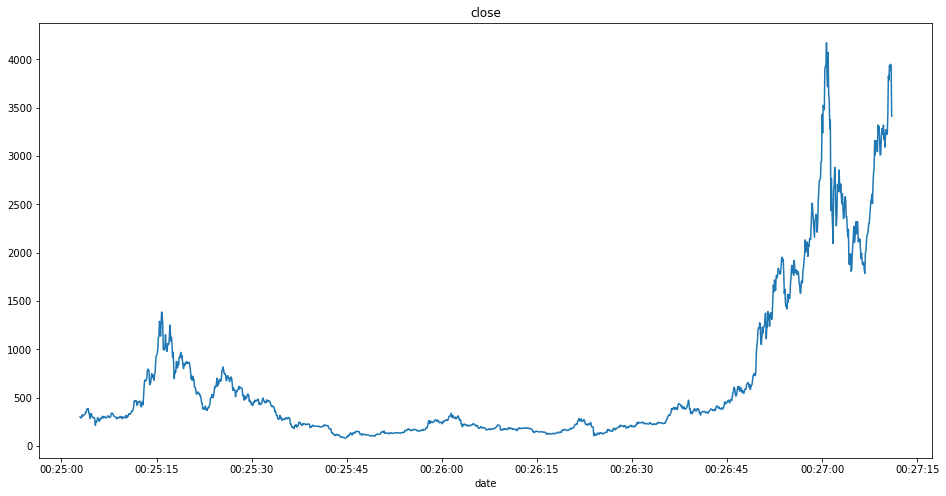

In [34]:
plt.figure(figsize=(16,8))
plt.title('close')
plt.plot(df['close'])
plt.xlabel('date')

In [35]:
qtd_linhas = len(df)
qtd_linhas_treino = round(.70 * qtd_linhas)
qtd_linhas_teste = qtd_linhas - qtd_linhas_treino
info = (
    f"linhas treino= 0:{qtd_linhas_treino}"
    f"linhas teste= {qtd_linhas_treino}:{qtd_linhas_teste + qtd_linhas_treino}"
)
info

'linhas treino= 0:1038linhas teste= 1038:1483'

In [36]:
#Normalizando os dados
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

In [37]:
#separando em treino e test
train = df_scaled[:qtd_linhas_treino]
test = df_scaled[qtd_linhas_treino: qtd_linhas_treino+qtd_linhas_teste]
print( len(train), len(test))

1038 445


In [38]:
#converter em array
def create_df(df, steps=1):
    dataX, dataY = [], []
    for i in range(len(df)-steps-1):
        a = df[i:(i + steps), 0]
        dataX.append(a)
        dataY.append(df[i + steps, 0])
    return np.array(dataX), np.array(dataY)

In [39]:
#gerar dados de treino e test
steps = 15
X_train, Y_train = create_df(train, steps)
X_test, Y_test = create_df(test, steps)

In [40]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(1022, 15)
(1022,)
(429, 15)
(429,)


In [41]:
#gerando dados que o modelo espea
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [42]:
#camade de rede neural
model = Sequential()
model.add(LSTM(35, return_sequences=True, input_shape=(steps,1)))
model.add(LSTM(35, return_sequences=True))
model.add(LSTM(35))
model.add(Dropout(0.2))
model.add(Dense(1))

In [43]:
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 15, 35)            5180      
_________________________________________________________________
lstm_4 (LSTM)                (None, 15, 35)            9940      
_________________________________________________________________
lstm_5 (LSTM)                (None, 35)                9940      
_________________________________________________________________
dropout_1 (Dropout)          (None, 35)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 36        
Total params: 25,096
Trainable params: 25,096
Non-trainable params: 0
_________________________________________________________________


In [44]:
#treinamento do modelo
validation = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=15, verbose=2)

Epoch 1/100
69/69 - 9s - loss: 0.0304 - val_loss: 1.0218
Epoch 2/100
69/69 - 3s - loss: 0.0097 - val_loss: 1.0211
Epoch 3/100
69/69 - 3s - loss: 0.0095 - val_loss: 0.9475
Epoch 4/100
69/69 - 3s - loss: 0.0082 - val_loss: 0.8956
Epoch 5/100
69/69 - 3s - loss: 0.0085 - val_loss: 0.8574
Epoch 6/100
69/69 - 3s - loss: 0.0073 - val_loss: 0.8013
Epoch 7/100
69/69 - 3s - loss: 0.0071 - val_loss: 0.7467
Epoch 8/100
69/69 - 3s - loss: 0.0068 - val_loss: 0.6821
Epoch 9/100
69/69 - 3s - loss: 0.0061 - val_loss: 0.4244
Epoch 10/100
69/69 - 2s - loss: 0.0060 - val_loss: 0.6063
Epoch 11/100
69/69 - 3s - loss: 0.0056 - val_loss: 0.2656
Epoch 12/100
69/69 - 3s - loss: 0.0056 - val_loss: 0.5157
Epoch 13/100
69/69 - 3s - loss: 0.0055 - val_loss: 0.5895
Epoch 14/100
69/69 - 4s - loss: 0.0051 - val_loss: 0.6083
Epoch 15/100
69/69 - 3s - loss: 0.0053 - val_loss: 0.5194
Epoch 16/100
69/69 - 4s - loss: 0.0043 - val_loss: 0.5064
Epoch 17/100
69/69 - 3s - loss: 0.0043 - val_loss: 0.5809
Epoch 18/100
69/69 - 4s

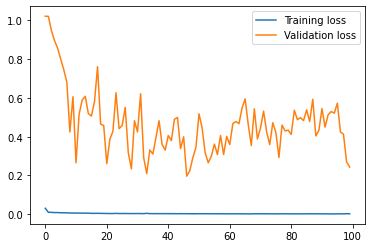

In [45]:
plt.plot(validation.history['loss'], label='Training loss')
plt.plot(validation.history['val_loss'], label='Validation loss')
plt.legend()

In [46]:
#fazendo a previsao 
prev = model.predict(X_test)
prev = scaler.inverse_transform(prev)
prev

array([[ 225.30243],
       [ 224.9997 ],
       [ 235.47037],
       [ 236.93793],
       [ 242.67053],
       [ 240.16068],
       [ 238.37604],
       [ 236.03064],
       [ 238.03247],
       [ 236.20743],
       [ 236.35254],
       [ 235.06848],
       [ 230.91357],
       [ 229.06042],
       [ 231.02026],
       [ 234.49265],
       [ 233.27377],
       [ 240.0734 ],
       [ 256.12234],
       [ 269.54266],
       [ 275.46634],
       [ 296.91058],
       [ 306.05   ],
       [ 315.99084],
       [ 312.7166 ],
       [ 311.5471 ],
       [ 324.65735],
       [ 336.8423 ],
       [ 374.02155],
       [ 367.79865],
       [ 377.48044],
       [ 380.97775],
       [ 390.57947],
       [ 386.15717],
       [ 371.35477],
       [ 383.59842],
       [ 379.53534],
       [ 383.75757],
       [ 370.0442 ],
       [ 374.78003],
       [ 408.80792],
       [ 426.959  ],
       [ 424.45074],
       [ 424.43997],
       [ 420.85837],
       [ 411.6208 ],
       [ 396.89545],
       [ 401.

In [47]:
#previsao para od proximos dias
lenght_test =len(test)
lenght_test

445

In [48]:
#pegando os ultimos dias do tamanho do meu step 
days_input_steps = lenght_test - steps
days_input_steps

430

In [49]:
#transforma em array
input_steps = test[days_input_steps:]
input_steps = np.array(input_steps).reshape(1,-1)
input_steps

array([[3.11833357, 3.18804494, 3.02238594, 3.24577215, 3.20986924,
        3.18383127, 3.19147784, 3.43879518, 3.9315709 , 3.88075906,
        4.06949407, 4.00431859, 4.0845889 , 4.05544026, 3.41792515]])

In [50]:
#tranformando em lista
list_output_steps = list(input_steps)
list_output_steps = list_output_steps[0].tolist()
list_output_steps

[3.118333570499493,
 3.188044938833078,
 3.0223859414081833,
 3.245772148379361,
 3.209869244546046,
 3.1838312739026926,
 3.1914778364381275,
 3.4387951815874658,
 3.9315709020639136,
 3.880759060256323,
 4.069494069741153,
 4.004318587773806,
 4.084588904697652,
 4.055440257885102,
 3.4179251470499095]

In [51]:
#loop para prever os proximos dias
pred_output=[]
i=0
n_future=10
while(i<n_future):
    if(len(list_output_steps) > steps):

        input_steps = np.array(list_output_steps[1:])

        print("{} dia, valores de entrada -> {}".format(i,input_steps))
        input_steps = input_steps.reshape(1,-1)
        input_steps = input_steps.reshape((1, steps, 1))
        # print(input_steps)
        pred = model.predict(input_steps, verbose=0)
        print("{} dia, valores de entrada -> {}".format(i,pred))
        list_output_steps.extend(pred[0].tolist())
        list_output_steps = list_output_steps[1:]
        # print(list_output_steps)
        pred_output.extend(pred.tolist())
        i=i+1
    else:
        input_steps = input_steps.reshape((1, steps,1))
        pred = model.predict(input_steps, verbose=0)
        print(pred[0])
        list_output_steps.extend(pred[0].tolist())
        print(len(list_output_steps))
        pred_output.extend(pred.tolist())
        i=i+1
print(pred_output)

[2.25943]
16
1 dia, valores de entrada -> [3.18804494 3.02238594 3.24577215 3.20986924 3.18383127 3.19147784
 3.43879518 3.9315709  3.88075906 4.06949407 4.00431859 4.0845889
 4.05544026 3.41792515 2.25942993]
1 dia, valores de entrada -> [[1.7020457]]
2 dia, valores de entrada -> [3.02238594 3.24577215 3.20986924 3.18383127 3.19147784 3.43879518
 3.9315709  3.88075906 4.06949407 4.00431859 4.0845889  4.05544026
 3.41792515 2.25942993 1.70204568]
2 dia, valores de entrada -> [[1.6583247]]
3 dia, valores de entrada -> [3.24577215 3.20986924 3.18383127 3.19147784 3.43879518 3.9315709
 3.88075906 4.06949407 4.00431859 4.0845889  4.05544026 3.41792515
 2.25942993 1.70204568 1.65832472]
3 dia, valores de entrada -> [[1.441865]]
4 dia, valores de entrada -> [3.20986924 3.18383127 3.19147784 3.43879518 3.9315709  3.88075906
 4.06949407 4.00431859 4.0845889  4.05544026 3.41792515 2.25942993
 1.70204568 1.65832472 1.44186497]
4 dia, valores de entrada -> [[1.1832516]]
5 dia, valores de entrada 

In [52]:
#tranforma a saida
prev = scaler.inverse_transform(pred_output)
prev = np.array(prev).reshape(1,-1)
list_output_prev = list(prev)
list_output_prev = prev[0].tolist()
list_output_prev

[2477.571924188022,
 2027.819395220201,
 1992.5410167648884,
 1817.8799637390698,
 1609.2052357406992,
 1484.792579653772,
 1393.6273986921246,
 1319.0493310269885,
 1264.1317850344994,
 1223.7525577057966]

In [53]:
#pagar datas de previsao
dates = pd.to_datetime(df_ori['date'])
predict_dates = pd.date_range(list(dates)[-1] + pd.DateOffset(1), periods=10).tolist()#freq='b'
predict_dates


[Timestamp('1970-01-02 00:27:10.972800', freq='D'),
 Timestamp('1970-01-03 00:27:10.972800', freq='D'),
 Timestamp('1970-01-04 00:27:10.972800', freq='D'),
 Timestamp('1970-01-05 00:27:10.972800', freq='D'),
 Timestamp('1970-01-06 00:27:10.972800', freq='D'),
 Timestamp('1970-01-07 00:27:10.972800', freq='D'),
 Timestamp('1970-01-08 00:27:10.972800', freq='D'),
 Timestamp('1970-01-09 00:27:10.972800', freq='D'),
 Timestamp('1970-01-10 00:27:10.972800', freq='D'),
 Timestamp('1970-01-11 00:27:10.972800', freq='D')]

In [54]:
#cria data frame de previsao 
forecast_dates = []
for i in predict_dates:
    forecast_dates.append(i.date())

df_forecast = pd.DataFrame({'date': np.array(forecast_dates), 'close': list_output_prev})
df_forecast['date'] = pd.to_datetime(df_forecast['date'])

df_forecast = df_forecast.set_index(pd.DatetimeIndex(df_forecast['date'].values))
df_forecast.drop('date',axis=1,inplace=True)
df_forecast

,close
1970-01-02,2477.571924
1970-01-03,2027.819395
1970-01-04,1992.541017
1970-01-05,1817.879964
1970-01-06,1609.205236
1970-01-07,1484.792580
1970-01-08,1393.627399
1970-01-09,1319.049331
1970-01-10,1264.131785
1970-01-11,1223.752558


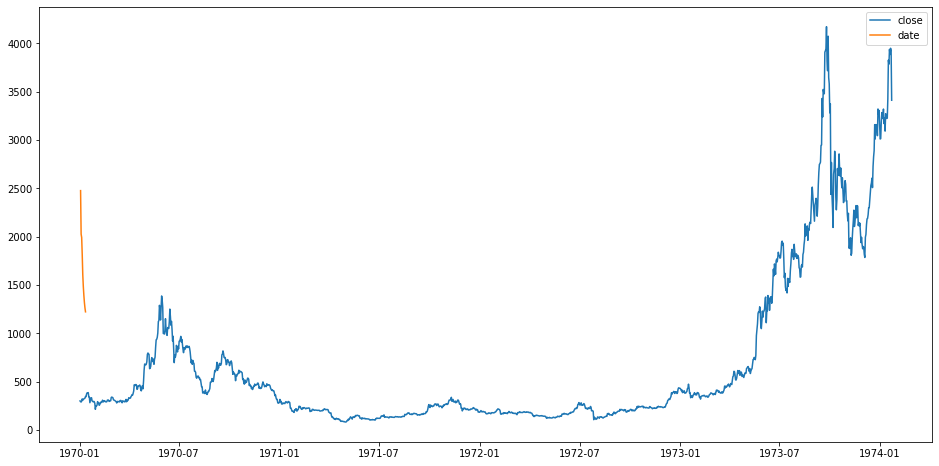

In [55]:
#plocar grafico
plt.figure(figsize=(16,8))
plt.plot(df_ori['close'])
plt.plot(df_forecast['close'])
plt.legend(['close', 'date'])
plt.show()